In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium

In [5]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/cooling_boiler_trimmed_3.csv'

# Import 
cooling_boiler_df = pd.read_csv(csv_file_path)  

# Verify the import
print(cooling_boiler_df.dtypes.to_string())

/var/folders/6r/kznwmt6j1rsfwtfplchqpwj00000gn/T/ipykernel_36596/1556384224.py:5: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  cooling_boiler_df = pd.read_csv(csv_file_path)


utility_id                                              int64
state                                                  object
plant_code                                              int64
plant_name                                             object
year                                                    int64
month                                                   int64
generator_id                                           object
boiler_id                                              object
cooling_id                                             object
generator_primary_technology                           object
fuel_consumption_from_all_fuel_types_mmbtu            float64
water_withdrawal_volume_million_gallons               float64
water_consumption_volume_million_gallons              float64
cooling_unit_hours_in_service                         float64
avg_distance_water_intake                             float64
cooling_type_1_860                                     object
cooling_

# Data Clean

In [17]:
# Remove rows where any of the columns have missing values
df_plot = cooling_boiler_df[['cooling_unit_hours_in_service', 'fuel_consumption_from_all_fuel_types_mmbtu', 'water_withdrawal_volume_million_gallons', 'water_consumption_volume_million_gallons']].dropna()

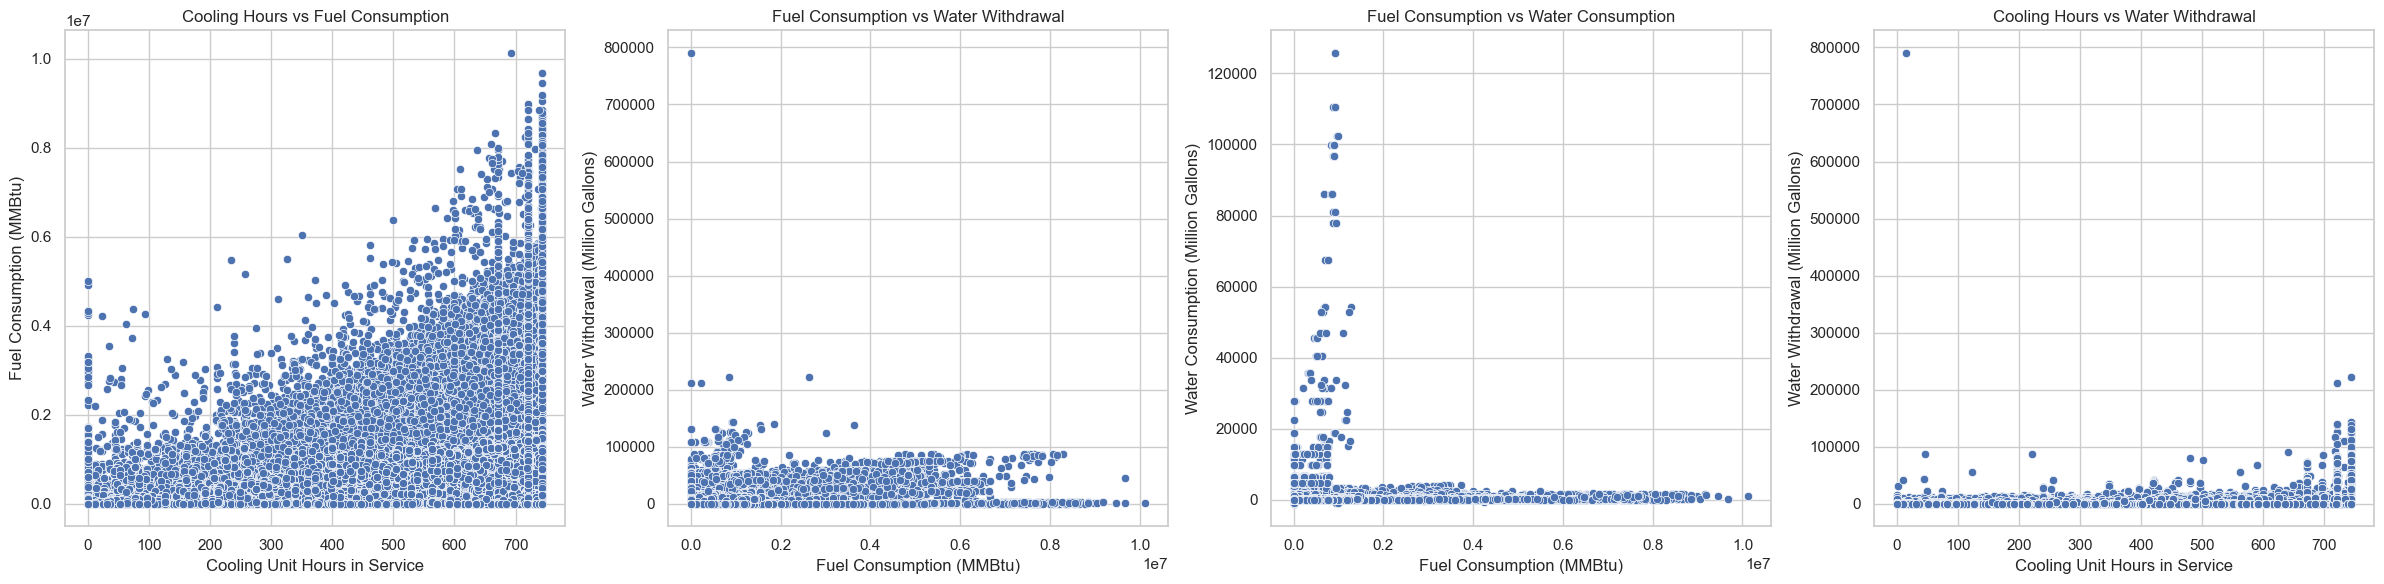

In [21]:
import matplotlib.pyplot as plt

# Create a new figure with 4 subplots (since we're adding one more plot)
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Plot 1: cooling_unit_hours_in_service vs. fuel_consumption_from_all_fuel_types_mmbtu
sns.scatterplot(x='cooling_unit_hours_in_service', y='fuel_consumption_from_all_fuel_types_mmbtu', data=df_plot, ax=axs[0])
axs[0].set_title("Cooling Hours vs Fuel Consumption")
axs[0].set_xlabel("Cooling Unit Hours in Service")
axs[0].set_ylabel("Fuel Consumption (MMBtu)")

# Plot 2: fuel_consumption_from_all_fuel_types_mmbtu vs. water_withdrawal_volume_million_gallons
sns.scatterplot(x='fuel_consumption_from_all_fuel_types_mmbtu', y='water_withdrawal_volume_million_gallons', data=df_plot, ax=axs[1])
axs[1].set_title("Fuel Consumption vs Water Withdrawal")
axs[1].set_xlabel("Fuel Consumption (MMBtu)")
axs[1].set_ylabel("Water Withdrawal (Million Gallons)")

# Plot 3: fuel_consumption_from_all_fuel_types_mmbtu vs. water_consumption_volume_million_gallons
sns.scatterplot(x='fuel_consumption_from_all_fuel_types_mmbtu', y='water_consumption_volume_million_gallons', data=df_plot, ax=axs[2])
axs[2].set_title("Fuel Consumption vs Water Consumption")
axs[2].set_xlabel("Fuel Consumption (MMBtu)")
axs[2].set_ylabel("Water Consumption (Million Gallons)")

# Plot 4: cooling_unit_hours_in_service vs. water_withdrawal_volume_million_gallons
sns.scatterplot(x='cooling_unit_hours_in_service', y='water_withdrawal_volume_million_gallons', data=df_plot, ax=axs[3])
axs[3].set_title("Cooling Hours vs Water Withdrawal")
axs[3].set_xlabel("Cooling Unit Hours in Service")
axs[3].set_ylabel("Water Withdrawal (Million Gallons)")

# Show the plots
plt.tight_layout()
plt.show()


# 🔎 Focusing in on Scatterplot 1: cooling_unit_hours_in_service vs. fuel_consumption

### Cooling Hours as a possible Proxy:
THere's a possibility that cooling hours could indeed serve as a proxy for something else, like the capacity or size of the plant (i.e., plants running longer hours might use more fuel). Or, the plot may reflect efficiency—if a plant is consuming more fuel but running fewer hours, maybe it's less efficient. 

### ✅ When Cooling Hours as a Proxy is Useful:
- When Fuel Data Is Missing or Noisy
If you're building a model or dashboard and fuel consumption data is missing, inconsistent, or delayed in reporting, but cooling unit hours are reliably reported, then using cooling hours as a proxy gives you something to work with.
- For Early Warning or Monitoring Systems
If you're designing an Edge AI or sustainability tool that needs to flag high fuel use in near-real-time, cooling hours could serve as a leading indicator—especially if fuel use can't be pulled immediately.
- In Regulatory or Planning Scenarios
Cooling hours may be more regulatable or trackable than fuel totals (e.g., for certain compliance purposes). So, being able to estimate expected fuel consumption from cooling hours can help with compliance checks.

#### If fuel consumption is missing a lot, but I have cooling hours and water use, can I estimate fuel use—and then derive efficiency metrics like water-per-MMBtu?

## 🎯 Goal:
Predict:
fuel_consumption_from_all_fuel_types_mmbtu (y - target)
from
cooling_unit_hours_in_service (X - feature)

# ✅ Step 1: Drop NaNs and Create NumPy Arrays

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Keep only rows where both values are not null
df_model = cooling_boiler_df[['cooling_unit_hours_in_service', 'fuel_consumption_from_all_fuel_types_mmbtu']].dropna()

# Independent variable (feature): X must be 2D for scikit-learn
X = df_model['cooling_unit_hours_in_service'].values.reshape(-1, 1)

# Dependent variable (target): y can be 1D
y = df_model['fuel_consumption_from_all_fuel_types_mmbtu'].values


# ✅ Step 2: Train/Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ✅ Step 3: Train the Model

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

# ✅ Step 4: Predict and Evaluate

In [40]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")


Mean Squared Error: 603392933253.69
R² Score: 0.086


# ✅ Step 5: Plot the Regression Line 

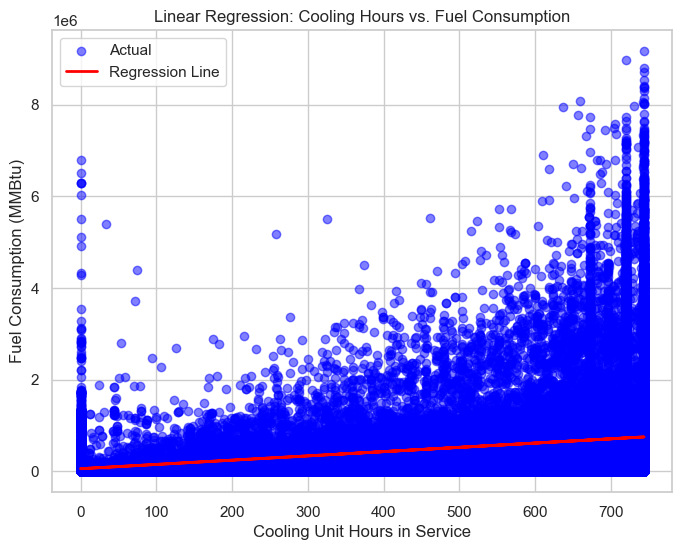

In [45]:
lg = plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel("Cooling Unit Hours in Service")
plt.ylabel("Fuel Consumption (MMBtu)")
plt.title("Linear Regression: Cooling Hours vs. Fuel Consumption")
plt.legend()
plt.show()


In [50]:
# Optional: Save the plot with a timestamped filename
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.4/fuel_hours_linear_reg.png'
lg.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.4/fuel_hours_linear_reg.png


# 📊 Model Interpretation
### (AZ+ChatGPT)
We used a simple linear regression model to explore the relationship between cooling_unit_hours_in_service and fuel_consumption_from_all_fuel_types_mmbtu. The regression line was fit on the training data and plotted against the test set.

The results suggest that **cooling hours alone are a poor predictor of fuel consumption**. The model's R² score was only **0.086**, meaning it explained just 8.6% of the variance in fuel consumption. Additionally, the mean squared error (MSE) was quite high, indicating that the predictions were far from the actual values on average.

Visually, while there was some upward trend, the data was highly scattered, and many points were far from the regression line.

This indicates that other variables (e.g., plant size, generator technology, fuel type) likely play a significant role in determining fuel consumption, and **a simple one-feature model is insufficient for accurate prediction.**

# 🧾 Compare Predicted vs. Actual in a DataFrame

In [57]:
# Compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Fuel Consumption': y_test,
    'Predicted Fuel Consumption': y_pred
})

# Optional: look at a sample
comparison_df.head(10)


,Actual Fuel Consumption,Predicted Fuel Consumption
0,0.0,370659.672781
1,321934.0,724939.470980
2,977271.0,696970.013227
3,668149.0,724939.470980
4,1185871.0,746382.721924
5,325.0,724939.470980
6,712851.0,722142.525205
7,615487.0,747315.037182
8,685636.0,724939.470980
9,578929.0,202842.926266


# Reflection on possible data bias 

### (AZ+ChatGPT)

One potential source of bias in this dataset may stem from differences in reporting practices between large and small power plants. Larger facilities, which consume more fuel and operate more cooling systems, are more likely to be subject to rigorous regulatory oversight and have dedicated resources for data collection and reporting. This could lead to higher data quality and completeness for large-scale operations.

On the other hand, smaller or off-the-grid plants may have less consistent reporting or fall outside federal reporting thresholds. This could skew the dataset toward larger facilities and bias any model trained on this data to reflect the operational patterns of those plants.

Additionally, if cooling_unit_hours_in_service is reported differently across plants—whether due to equipment differences, automation, or human error—then it introduces a potential measurement bias in the independent variable itself. This would weaken its predictive power for modeling fuel consumption.

Overall, recognizing and accounting for these systemic differences is crucial in building robust and equitable models, particularly for infrastructure and environmental monitoring.